# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [25]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [26]:
#today = datetime.datetime.now() - datetime.timedelta(0)
#today = datetime.date.today()
today = datetime.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
today_str = today.isoformat()  # Convert to ISO 8601 format
tomorrow = today + datetime.timedelta(days = 1)
today_date = datetime.datetime.today().date()  # Get the current date without time
today

datetime.datetime(2024, 11, 21, 0, 0)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [27]:
#os.environ["HOPSWORKS_API_KEY"] = "C4SS8dsi1TSlBcSM.FQPsjTGnxcG3aKFbWq1yzAaBw0jRlpCtRB2l7ESP9MGqHKgjMCRbpjOjbdPzJwLp"
with open('../../data/hopsworks-api-key.txt') as f:
    api_key = f.readline().strip()
    print("Read Hopsworks API key from file")
    os.environ["HOPSWORKS_API_KEY"] = api_key

project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Read Hopsworks API key from file
Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1163417
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [28]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [29]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [30]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.5844874E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [31]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.66s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-28 00:00:00+00:00,4.10,0.0,13.755579,47.121109,Majorna-Linné
1,2024-11-22 00:00:00+00:00,-0.50,0.0,9.686609,131.987137,Majorna-Linné
2,2024-11-25 00:00:00+00:00,10.55,0.3,28.496904,183.621414,Majorna-Linné
3,2024-11-21 00:00:00+00:00,-1.25,0.0,9.360001,337.380096,Majorna-Linné
4,2024-11-23 00:00:00+00:00,3.05,0.0,12.522619,288.435028,Majorna-Linné
5,2024-11-26 00:00:00+00:00,8.10,0.4,23.023117,206.965637,Majorna-Linné
6,2024-11-24 00:00:00+00:00,4.30,0.9,28.948118,158.860107,Majorna-Linné
7,2024-11-27 00:00:00+00:00,7.35,0.2,10.931203,162.758453,Majorna-Linné
8,2024-11-29 00:00:00+00:00,0.10,0.0,12.481153,33.231728,Majorna-Linné
9,2024-11-30 00:00:00+00:00,1.60,0.0,2.595997,123.690094,Majorna-Linné


In [32]:
# Get weather data
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

air_quality_fg = fs.get_feature_group(
    name='air_quality_v3',
    version=2,
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.59s) 


In [33]:
# Read the air_quality feature group
air_data = air_quality_fg.read()
air_data['date'] = pd.to_datetime(air_data['date']).dt.date  # Strip time part

# Filter for today's data
air_data_today = air_data[air_data['date'] == today_date]

print("air_data_today:", air_data_today)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.05s) 
air_data_today:             date  pm25 country           city      street  \
1757  2024-11-21   2.0  Sweden  Majorna-Linné  Masthugget   

                                     url  pm25_lag_1  pm25_lag_2  pm25_lag_3  
1757  https://api.waqi.info/feed/A60853/         2.0         7.0    2.620594  


In [34]:
print(air_data)

            date  pm25 country           city      street  \
0     2021-06-21  1.40  Sweden  Majorna-Linné  Masthugget   
1     2019-12-27  0.98  Sweden  Majorna-Linné  Masthugget   
2     2020-01-11  2.04  Sweden  Majorna-Linné  Masthugget   
3     2023-02-01  2.06  Sweden  Majorna-Linné  Masthugget   
4     2022-04-03  1.40  Sweden  Majorna-Linné  Masthugget   
...          ...   ...     ...            ...         ...   
1753  2024-06-17  1.00  Sweden  Majorna-Linné  Masthugget   
1754  2021-11-08  0.60  Sweden  Majorna-Linné  Masthugget   
1755  2024-11-19  7.00  Sweden  Majorna-Linné  Masthugget   
1756  2024-11-20  2.00  Sweden  Majorna-Linné  Masthugget   
1757  2024-11-21  2.00  Sweden  Majorna-Linné  Masthugget   

                                     url  pm25_lag_1  pm25_lag_2  pm25_lag_3  
0     https://api.waqi.info/feed/A60853/    3.520000    3.080000    3.870000  
1     https://api.waqi.info/feed/A60853/    0.770000    1.350000    1.700000  
2     https://api.waqi.info/fe

In [35]:
# check if pm25 for today is missing / is NaN
if air_data_today['pm25'].isnull().values.any():
    print("pm25 for today is missing")
    # Get the weather data for today
    weather_data_today = batch_data[batch_data['date'] == today_date]
    print("weather_data_today:", weather_data_today)
    # Prepare the input data for the model
    input_data = weather_data_today.drop(['date'], axis=1)
    print("input_data:", input_data)
    # Predict the pm25 value for today
    predicted_pm25 = retrieved_xgboost_model.predict(input_data)
    print("predicted_pm25:", predicted_pm25)
    # Update the air_quality feature group with the predicted pm25 value
    air_data_today['pm25'] = predicted_pm25
    print("air_data_today:", air_data_today)
    # Write the updated air_quality feature group to the feature store
    air_quality_fg.save(air_data_today)
    print("Updated air_quality feature group with predicted pm25 value")

In [36]:
batch_data
batch_data['pm25_lag_1'] = air_data_today['pm25'].values[0]
batch_data['pm25_lag_2'] = air_data_today['pm25_lag_1'].values[0]
batch_data['pm25_lag_3'] = air_data_today['pm25_lag_2'].values[0]

# Ensure batch_data['date'] is a datetime object with no time (convert if needed)
batch_data['date'] = pd.to_datetime(batch_data['date']).dt.date  # Strip time from date


In [37]:
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3
0,2024-11-28,4.10,0.0,13.755579,47.121109,Majorna-Linné,2.0,2.0,7.0
1,2024-11-22,-0.50,0.0,9.686609,131.987137,Majorna-Linné,2.0,2.0,7.0
2,2024-11-25,10.55,0.3,28.496904,183.621414,Majorna-Linné,2.0,2.0,7.0
3,2024-11-21,-1.25,0.0,9.360001,337.380096,Majorna-Linné,2.0,2.0,7.0
4,2024-11-23,3.05,0.0,12.522619,288.435028,Majorna-Linné,2.0,2.0,7.0
5,2024-11-26,8.10,0.4,23.023117,206.965637,Majorna-Linné,2.0,2.0,7.0
6,2024-11-24,4.30,0.9,28.948118,158.860107,Majorna-Linné,2.0,2.0,7.0
7,2024-11-27,7.35,0.2,10.931203,162.758453,Majorna-Linné,2.0,2.0,7.0
8,2024-11-29,0.10,0.0,12.481153,33.231728,Majorna-Linné,2.0,2.0,7.0
9,2024-11-30,1.60,0.0,2.595997,123.690094,Majorna-Linné,2.0,2.0,7.0


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [38]:
# Run inference for each day sequentially, starting from the first day
for i in range(len(batch_data)-1):
    #print(f"Running inference for day {i+1}")
    current_day = today_date + datetime.timedelta(days=i+1)  # Current day (start with tomorrow)
    tomorrow = today_date + datetime.timedelta(days=i+2)  # Day after tomorrow
    
    # Filter the data for the current day
    pred_data = batch_data[batch_data['date'] == current_day]
    lag_2 = pred_data['pm25_lag_1'].values[0]
    lag_3 = pred_data['pm25_lag_2'].values[0]

    print(f"Running inference for {current_day}")
    
    # Make the prediction for the current day
    pm25_pred = retrieved_xgboost_model.predict(
        pred_data[['pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']]
    )
    
    # Add the prediction to the 'pm25_pred' column for the current day
    batch_data.loc[batch_data['date'] == current_day, 'predicted_pm25'] = pm25_pred

    batch_data.loc[batch_data['date'] == tomorrow, 'pm25_lag_1'] = pm25_pred  # Today's prediction for tomorrow's lag_1
    batch_data.loc[batch_data['date'] == tomorrow, 'pm25_lag_2'] = lag_2  # Today's lag_1 for tomorrow's lag_2
    batch_data.loc[batch_data['date'] == tomorrow, 'pm25_lag_3'] = lag_3  # Today's lag_2 for tomorrow's lag_3
    print(f"Predicted PM2.5 for {current_day}: {pm25_pred}")

# Show the final predictions and lag columns
print(batch_data[['date', 'predicted_pm25', 'pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3']])


Running inference for 2024-11-22
Predicted PM2.5 for 2024-11-22: [4.3833323]
Running inference for 2024-11-23
Predicted PM2.5 for 2024-11-23: [3.0422266]
Running inference for 2024-11-24
Predicted PM2.5 for 2024-11-24: [3.318199]
Running inference for 2024-11-25
Predicted PM2.5 for 2024-11-25: [5.562729]
Running inference for 2024-11-26
Predicted PM2.5 for 2024-11-26: [4.680026]
Running inference for 2024-11-27
Predicted PM2.5 for 2024-11-27: [6.680069]
Running inference for 2024-11-28
Predicted PM2.5 for 2024-11-28: [3.11925]
Running inference for 2024-11-29
Predicted PM2.5 for 2024-11-29: [2.399036]
Running inference for 2024-11-30
Predicted PM2.5 for 2024-11-30: [2.7899399]
         date  predicted_pm25  pm25_lag_1  pm25_lag_2  pm25_lag_3
0  2024-11-28        3.119250    6.680069    4.680026    5.562729
1  2024-11-22        4.383332    2.000000    2.000000    7.000000
2  2024-11-25        5.562729    3.318199    3.042227    4.383332
3  2024-11-21             NaN    2.000000    2.000

In [39]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         10 non-null     object 
 1   temperature_2m_mean          10 non-null     float32
 2   precipitation_sum            10 non-null     float32
 3   wind_speed_10m_max           10 non-null     float32
 4   wind_direction_10m_dominant  10 non-null     float32
 5   city                         10 non-null     object 
 6   pm25_lag_1                   10 non-null     float32
 7   pm25_lag_2                   10 non-null     float64
 8   pm25_lag_3                   10 non-null     float64
 9   predicted_pm25               9 non-null      float32
dtypes: float32(6), float64(2), object(2)
memory usage: 692.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [40]:
# Assuming 'batch_data' and 'forecast_date' are already defined
# Ensure 'date' is in datetime format (if it's not already)
batch_data['date'] = pd.to_datetime(batch_data['date'], errors='coerce').dt.date

# Define forecast date as a pandas Timestamp
forecast_date = pd.to_datetime(datetime.date.today())  # This will convert to 'datetime64[ns]'

# Sort the DataFrame by 'date' to ensure it is in ascending order
batch_data = batch_data.sort_values(by=['date'])

# Calculate the 'days_before_forecast_day' based on the difference between each 'date' and the 'forecast_date'
batch_data['days_before_forecast_day'] = (forecast_date - pd.to_datetime(batch_data['date'])).dt.days.abs()

# Assign new columns
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country

# View the updated DataFrame
batch_data



,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25,days_before_forecast_day,street,country
3,2024-11-21,-1.25,0.0,9.360001,337.380096,Majorna-Linné,2.000000,2.000000,7.000000,NaN,0,Masthugget,Sweden
1,2024-11-22,-0.50,0.0,9.686609,131.987137,Majorna-Linné,2.000000,2.000000,7.000000,4.383332,1,Masthugget,Sweden
4,2024-11-23,3.05,0.0,12.522619,288.435028,Majorna-Linné,4.383332,2.000000,2.000000,3.042227,2,Masthugget,Sweden
6,2024-11-24,4.30,0.9,28.948118,158.860107,Majorna-Linné,3.042227,4.383332,2.000000,3.318199,3,Masthugget,Sweden
2,2024-11-25,10.55,0.3,28.496904,183.621414,Majorna-Linné,3.318199,3.042227,4.383332,5.562729,4,Masthugget,Sweden
5,2024-11-26,8.10,0.4,23.023117,206.965637,Majorna-Linné,5.562729,3.318199,3.042227,4.680026,5,Masthugget,Sweden
7,2024-11-27,7.35,0.2,10.931203,162.758453,Majorna-Linné,4.680026,5.562729,3.318199,6.680069,6,Masthugget,Sweden
0,2024-11-28,4.10,0.0,13.755579,47.121109,Majorna-Linné,6.680069,4.680026,5.562729,3.119250,7,Masthugget,Sweden
8,2024-11-29,0.10,0.0,12.481153,33.231728,Majorna-Linné,3.119250,6.680069,4.680026,2.399036,8,Masthugget,Sweden
9,2024-11-30,1.60,0.0,2.595997,123.690094,Majorna-Linné,2.399036,3.119250,6.680069,2.789940,9,Masthugget,Sweden


In [41]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 3 to 9
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         10 non-null     object 
 1   temperature_2m_mean          10 non-null     float32
 2   precipitation_sum            10 non-null     float32
 3   wind_speed_10m_max           10 non-null     float32
 4   wind_direction_10m_dominant  10 non-null     float32
 5   city                         10 non-null     object 
 6   pm25_lag_1                   10 non-null     float32
 7   pm25_lag_2                   10 non-null     float64
 8   pm25_lag_3                   10 non-null     float64
 9   predicted_pm25               9 non-null      float32
 10  days_before_forecast_day     10 non-null     int64  
 11  street                       10 non-null     object 
 12  country                      10 non-null     object 
dtypes: float32(6), float64(2), i

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

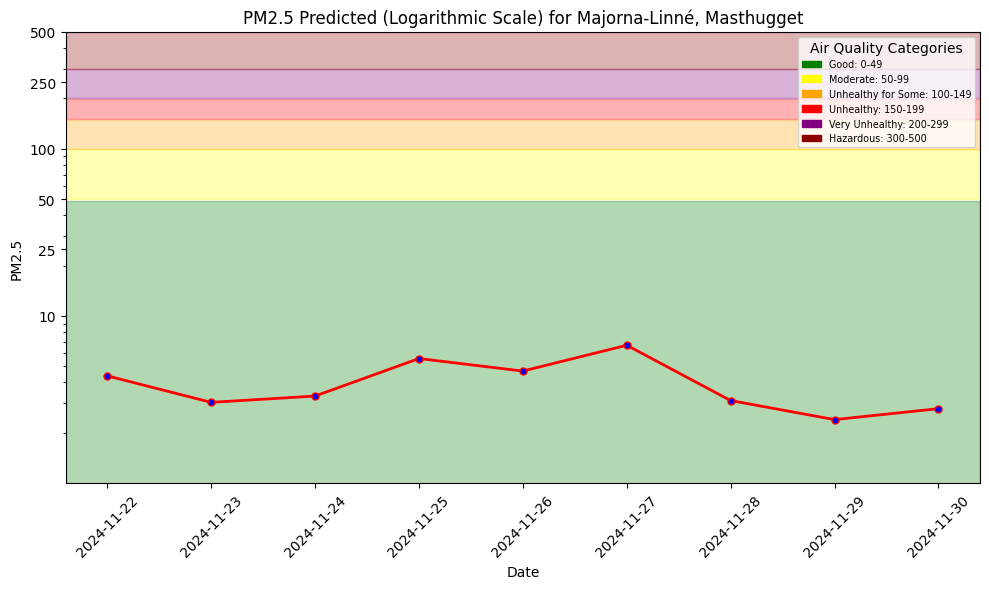

In [42]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [43]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [44]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/10 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1163417/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x1dfec7ee990>, None)

In [45]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.66s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25,days_before_forecast_day,street,country
0,2024-11-20,0.85,0.0,14.440443,4.289077,Majorna-Linné,8.0,2.620594,2.620594,2.794622,1,Masthugget,Sweden
1,2024-11-21,-0.75,0.0,10.365251,339.676788,Majorna-Linné,2.0,7.000000,2.620594,1.353514,1,Masthugget,Sweden
2,2024-11-22,-0.50,0.0,9.686609,131.987137,Majorna-Linné,2.0,2.000000,7.000000,4.383332,1,Masthugget,Sweden


In [46]:
air_quality_fg = fs.get_feature_group(
    name='air_quality_v3',
    version=2,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.14s) 


,date,pm25,country,city,street,url,pm25_lag_1,pm25_lag_2,pm25_lag_3
0,2021-06-21 00:00:00+00:00,1.40,Sweden,Majorna-Linné,Masthugget,https://api.waqi.info/feed/A60853/,3.520000,3.080000,3.870000
1,2019-12-27 00:00:00+00:00,0.98,Sweden,Majorna-Linné,Masthugget,https://api.waqi.info/feed/A60853/,0.770000,1.350000,1.700000
2,2020-01-11 00:00:00+00:00,2.04,Sweden,Majorna-Linné,Masthugget,https://api.waqi.info/feed/A60853/,0.850000,2.100000,3.160000
3,2023-02-01 00:00:00+00:00,2.06,Sweden,Majorna-Linné,Masthugget,https://api.waqi.info/feed/A60853/,1.120000,1.530000,2.200000
4,2022-04-03 00:00:00+00:00,1.40,Sweden,Majorna-Linné,Masthugget,https://api.waqi.info/feed/A60853/,1.100000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...
1753,2024-06-17 00:00:00+00:00,1.00,Sweden,Majorna-Linné,Masthugget,https://api.waqi.info/feed/A60853/,0.950000,1.600000,2.400000
1754,2021-11-08 00:00:00+00:00,0.60,Sweden,Majorna-Linné,Masthugget,https://api.waqi.info/feed/A60853/,1.200000,1.970000,0.870000
1755,2024-11-19 00:00:00+00:00,7.00,Sweden,Majorna-Linné,Masthugget,https://api.waqi.info/feed/A60853/,2.620594,2.620594,2.620594
1756,2024-11-20 00:00:00+00:00,2.00,Sweden,Majorna-Linné,Masthugget,https://api.waqi.info/feed/A60853/,7.000000,2.620594,2.620594


In [47]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

print(outcome_df, 'outcome_df')
print(preds_df, 'preds_df')

# Convert 'date' columns to datetime, removing any time zone info if necessary
outcome_df['date'] = pd.to_datetime(outcome_df['date']).dt.tz_localize(None)  # Remove timezone if present
preds_df['date'] = pd.to_datetime(preds_df['date']).dt.tz_localize(None)  # Remove timezone if present

# Now merge the DataFrames
hindcast_df = pd.merge(preds_df, outcome_df, on="date")

# View the resulting DataFrame
print(hindcast_df)

hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
#if len(hindcast_df) == 0:
    #hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

                          date  pm25
0    2021-06-21 00:00:00+00:00  1.40
1    2019-12-27 00:00:00+00:00  0.98
2    2020-01-11 00:00:00+00:00  2.04
3    2023-02-01 00:00:00+00:00  2.06
4    2022-04-03 00:00:00+00:00  1.40
...                        ...   ...
1753 2024-06-17 00:00:00+00:00  1.00
1754 2021-11-08 00:00:00+00:00  0.60
1755 2024-11-19 00:00:00+00:00  7.00
1756 2024-11-20 00:00:00+00:00  2.00
1757 2024-11-21 00:00:00+00:00  2.00

[1758 rows x 2 columns] outcome_df
         date  predicted_pm25
0  2024-11-20        2.794622
1  2024-11-21        1.353514
2  2024-11-22        4.383332 preds_df
2024-11-21 15:39:21,881 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2024-11-21 15:39:21,883 WARNING: SettingWithCopyWarning: 
A value is 

,date,predicted_pm25,pm25
0,2024-11-20,2.794622,2.0
1,2024-11-21,1.353514,2.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

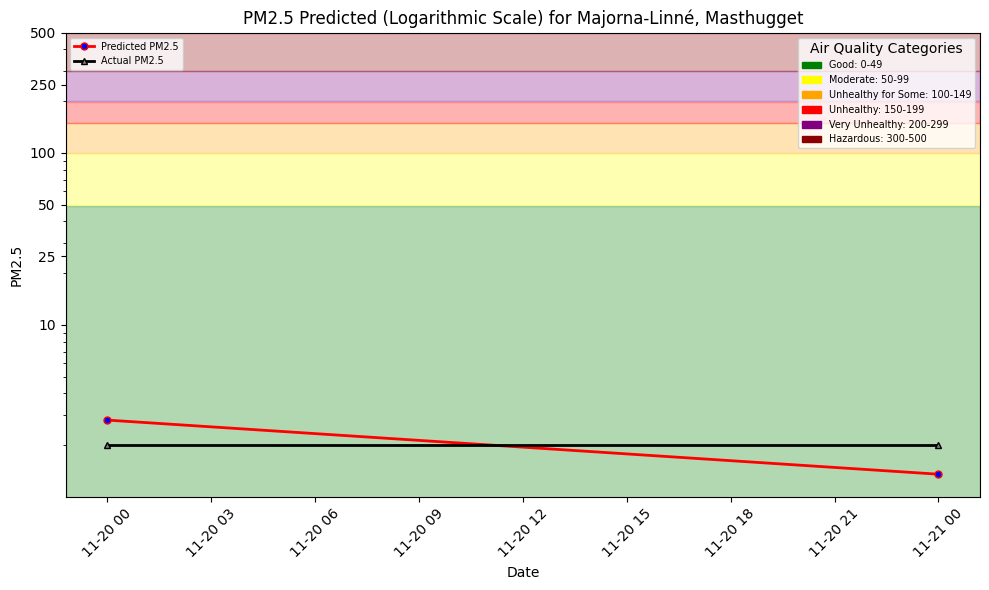

In [ ]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
#file_path = "../../docs/air-quality/assets/img/test.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---